Your goal is to test the performance of spectral clustering and a simple semi-supervised regression algorithm
on the 1984 house voting records data set. Download the data set called house-votes-84.data, and the
description house-votes-84.names. The data set consists of voting records of 435 members of the House
on 16 bills. There are 267 members of the democratic party and 168 members of the republican party. The
voting record of each house member on the 16 bills will be our input x while the corresponding output/class
𝑦 is that members party affiliation (republican or democrat embedded as  1).

In [24]:
import numpy as np
import scipy.spatial as ss
from scipy.sparse import csgraph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load

Your first task is to import and preprocess the data set. Construct your output vector y by assigning
labels {−1, +1} to members of different parties. Then construct the input vectors x𝑗 corresponding to
the voting records of each member by replacing ’y’ votes with +1, ’n’ votes with −1 and ’?’ with 0.
You do not need to center and normalize the data set in this case. This leads to a vector y ∈ R435 and
input matrix 𝑋 ∈ R435 16. Note that we are using the sklearn convention for our 𝑋 matrix.

In [2]:
# Load/Preprocess Data
data = np.loadtxt('/content/drive/MyDrive/AMATH/house-votes-84.data', dtype=object, delimiter=',')
data[(data == 'republican') | (data == 'n')] = -1.
data[(data == 'democrat') | (data == 'y')] = 1.
data[data == '?'] = 0
X, y = data[:, 1:], data[:, 0]; print(X.shape, y.shape)

(435, 16) (435,)


# Functions

In [31]:
def unnorm_lap(x, s):
  '''
  Function to calculate unnormalized laplacian matrix, adopted from
  https://graphsandnetworks.com/using-laplacians-for-graph-learning/
  Unnormalized Lap: L = D-A, needs x to be a square matrix
  '''
  A = np.exp(-(x**2)/(2 * s**2)).astype(float) # adjacency matrix using the weight function
  D = np.diag(np.sum(A, axis=1)) # degree matrix
  L = D - A # graph laplacian
  lam, Q = np.linalg.eigh(L) # eigenvalues and vectors
  '''
  it is helpful to plot q1 by re-ordering 𝑋 according to the original party 
  affiliations. For example, plot the q1 values for the 168 republicans 
  first then the 267 democrats. This will nicely visualize the behavior 
  of q1 on the two clusters.
  '''
  sort_idx = lam.argsort(); lam_sort = lam[sort_idx] ; Q_sort = Q[:, sort_idx]
  return lam_sort, Q_sort

def accuracy_(q1, y):
  '''
  Take sign(q1) as your classifier and compute its classification accuracy after comparison with y
  '''
  pred = np.sign(q1[:, 1]); correct = np.count_nonzero(pred == y); 
  accuracy = 1 - ((1 / 435) * correct ); accuracy = max(accuracy, 1 - accuracy)
  return accuracy

def acc_best(acc):
  '''
  takes in a list of accuracies for each q1 compared to y 
  '''
  best_accuracy_idx = np.argmax(acc); best_accuracy = accuracies[best_accuracy_idx]; best_sigma = sigs[best_accuracy_idx]
  return best_sigma, best_accuracy

def plot_acc(s, acc, bs, ba):
  fig = plt.figure(figsize=(5,4)); sns.set_context('talk')
  plt.scatter(s, acc, label='accuracies')
  plt.plot(bs, ba, 'r*', markersize=5, label='optimal sigma')
  plt.xlabel('sigma'); plt.ylabel('Classification Accuracy'); plt.legend(); plt.show()

def ssl_acc(J, M, Q, y):
  '''
  Use linear regression (least squares) to find Beta, takes in sign(Q), then take y as predictor
  of classes of all points in 𝑋, provides a table summarizing the accuracy of y_hat as your classifier
  '''
  ssl_accs = np.empty((len(J), len(M))) # Results vector of J rows and M columns
  model = LinearRegression(fit_intercept=False) #ssl
  for ji, j in enumerate(J): # Js
      for mi, m in enumerate(M): # Ms
          A = Q[0:j, 0:m]; b = y[0:j]; model.fit(A, b) # make A and b and fit on model on them
          bs = model.coef_ # coefficients
          y_hat = np.sign(np.dot(Q[:, 0:m] , bs)) #predict
          correct = np.count_nonzero(y_hat == y); accuracy = 1 - ((1 / 435) * correct) # how many are correct and convert to accuracy
          ssl_accs[ji, mi] = accuracy # table of accuracies
  return 1 - ssl_accs # number accurate vs inaccurate

# (Spectral Clustering): 
In this step you will mainly work with the matrix 𝑋 and use y for validation of your clustering algorithm.

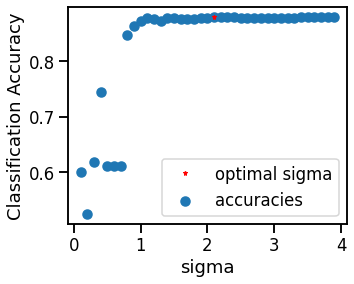

best sigma =  2.1 best accuracy =  88.04597701149426


In [30]:
# compressed-sparse graph, with shape (N, N)
# List of accuracies []
X_spatial = ss.distance_matrix(X, X, p=2); sigs = np.arange(0.1, 4, step=0.1); accuracies = []
for s in sigs: # iterate through all sigma
    lam, Q = unnorm_lap(X_spatial, s) # Generate Laplacian
    s_acc = accuracy_(Q, y) ; accuracies.append(s_acc)
# best accuraciess and plots
bs , ba = acc_best(accuracies); plot_acc(sigs, accuracies, bs, ba)
print ("best sigma = ", bs, "best accuracy = ", ba *100)

# (Semi-supervised Learning):

In [32]:
# Run models using Q_opt
J = [5, 10, 20, 40] # J values to consider (rows)
M = [2, 3, 4, 5, 6] # M values to consider (columns)
ssl_acc(J, M, Q, y)

array([[0.86436782, 0.90574713, 0.68045977, 0.68735632, 0.69885057],
       [0.86436782, 0.86666667, 0.92183908, 0.88275862, 0.67356322],
       [0.87586207, 0.88735632, 0.91494253, 0.90804598, 0.89195402],
       [0.87816092, 0.88965517, 0.90114943, 0.92873563, 0.91724138]])

the above visualization trick is also helpful in Step 3,

In [ ]:
'''
# just in case I need it in this form:

features =  ['Class','handicapped-infants', 'water-project-cost-sharing', 
                    'adoption-of-the-budget-resolution', 'physician-fee-freeze',
                    'el-salvador-aid', 'religious-groups-in-schools',
                    'anti-satellite-test-ban', 'aid-to-nicaraguan-contras',
                    'mx-missle', 'immigration', 'synfuels-corporation-cutback',
                    'education-spending', 'superfund-right-to-sue', 'crime',
                    'duty-free-exports', 'export-administration-act-south-africa']

votes_df = pd.DataFrame(votes, columns=features); X, y = votes_df.iloc[:, 1:], votes_df.iloc[:, 0]

'''